## Social IQa: Multiple Choice

* Name on HuggingFace Hub will be changed to reflect true nature of model (Multiple Choice, not Q&A)

Dataset Source: https://www.kaggle.com/datasets/thedevastator/social-i-qa-a-dataset-for-social-inquiry-questio

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

from dataclasses import dataclass

import transformers
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from transformers import Trainer, TrainingArguments, set_seed
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy

from typing import Optional, Union

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.12
         NumPy: 1.24.2
        Pandas: 1.5.0
         Torch: 1.12.1
      Datasets: 2.9.0
  Transformers: 4.26.1


#### Load & Process Training Dataset

In [3]:
parent_dir = "/Users/briandunn/Desktop/nlp_ds/Question_&_Answer/Social IQa (Social Interaction Q&A)"

train_ds_file = os.path.join(parent_dir, "train.csv")

train_ds = pd.read_csv(train_ds_file)

train_ds = train_ds.dropna()

train_ds = train_ds.drop_duplicates(subset=["context", "question"])

update_feature_names = {"answerA": 0, "answerB": 1, "answerC": 2}
train_ds["label"] = train_ds["label"] - 1

train_ds.rename(columns=update_feature_names, inplace=True)

train_ds

,context,question,0,1,2,label
0,Cameron decided to have a barbecue and gathere...,How would Others feel as a result?,like attending,like staying home,a good friend to have,0
1,Jan needed to give out jobs for an upcoming pr...,What will Others want to do next?,disagree with Jan,get to work,argue with the assignments,1
2,Remy was an expert fisherman and was on the wa...,What will Remy want to do next?,cast the line,put the boat in the water,invite Kai out on the boat,0
3,Addison gave a hug to Skylar's son when they w...,Why did Addison do this?,better,wrong,keep hugging the son,0
4,Kai found one for sale online but it was too m...,What does Kai need to do before this?,cheaper,Open up her laptop,save money,1
...,...,...,...,...,...,...
33405,Skylar wanted to kill jan that day because jan...,What will happen to Skylar?,she will get yelled at,have to control themselves,be happy,1
33406,Aubrey offered tribute to the gods. They did t...,How would Others feel as a result?,they were diffierent,religious and spiritual,they were unique,1
33407,Robin tapped the coach on the shoulder to brin...,What will the coach want to do next?,praise Robin,watch the competition,wrong,0
33408,kendall stretched lee out and focused on the l...,What will Lee want to do next?,get some exercise,ignore some exercise,avoid a run,0


#### Load & Process Evaluation Dataset

In [4]:
eval_ds_file = os.path.join(parent_dir, "validation.csv")

eval_ds = pd.read_csv(eval_ds_file)

eval_ds = eval_ds.dropna()

eval_ds = eval_ds.drop_duplicates(subset=["context", "question"])

update_feature_names = {"answerA": 0, "answerB": 1, "answerC": 2}
eval_ds.rename(columns=update_feature_names, inplace=True)

eval_ds["label"] = eval_ds["label"] - 1

eval_ds

,context,question,0,1,2,label
0,Tracy didn't go home that evening and resisted...,What does Tracy need to do before this?,make a new plan,Go home and see Riley,Find somewhere to go,2
1,Sydney walked past a homeless woman asking for...,How would you describe Sydney?,sympathetic,like a person who was unable to help,incredulous,0
2,Sasha protected the patients' rights by making...,What will patients want to do next?,write new laws,get petitions signed,live longer,1
3,Jordan was in charge of taking the food on the...,How would Jordan feel afterwards?,horrible that he let his friends down on the c...,happy that he doesn't need to do the cooking o...,very proud and accomplished about the camping ...,0
4,Kendall opened their mouth to speak and what c...,How would you describe Kendall?,a very quiet person,a very passive person,a very aggressive and talkative person,2
...,...,...,...,...,...,...
1949,Bailey destroyed the enemy's bunker and won th...,What does Bailey need to do before this?,spy on enemy troop movements,give the enemy counterintelligence,win the war for his country,0
1950,Kai told Kendall the reason about the accident...,How would you describe Kai?,more at ease,like they got something off their chest,feeling sad,1
1951,Kai improved Jan's picture and she loved how i...,What will Jan want to do next?,wanted to be helpful,wanted to Jan to be glad,frame the picture,2
1952,Tracy's kids wanted ice cream so Aubrey fed th...,What does Aubrey need to do before this?,tell her kids to say thank you,get ice cream,thanks Aubrey,1


#### Visual: Length of Training Dataset Contexts & Questions Combined (in Words)

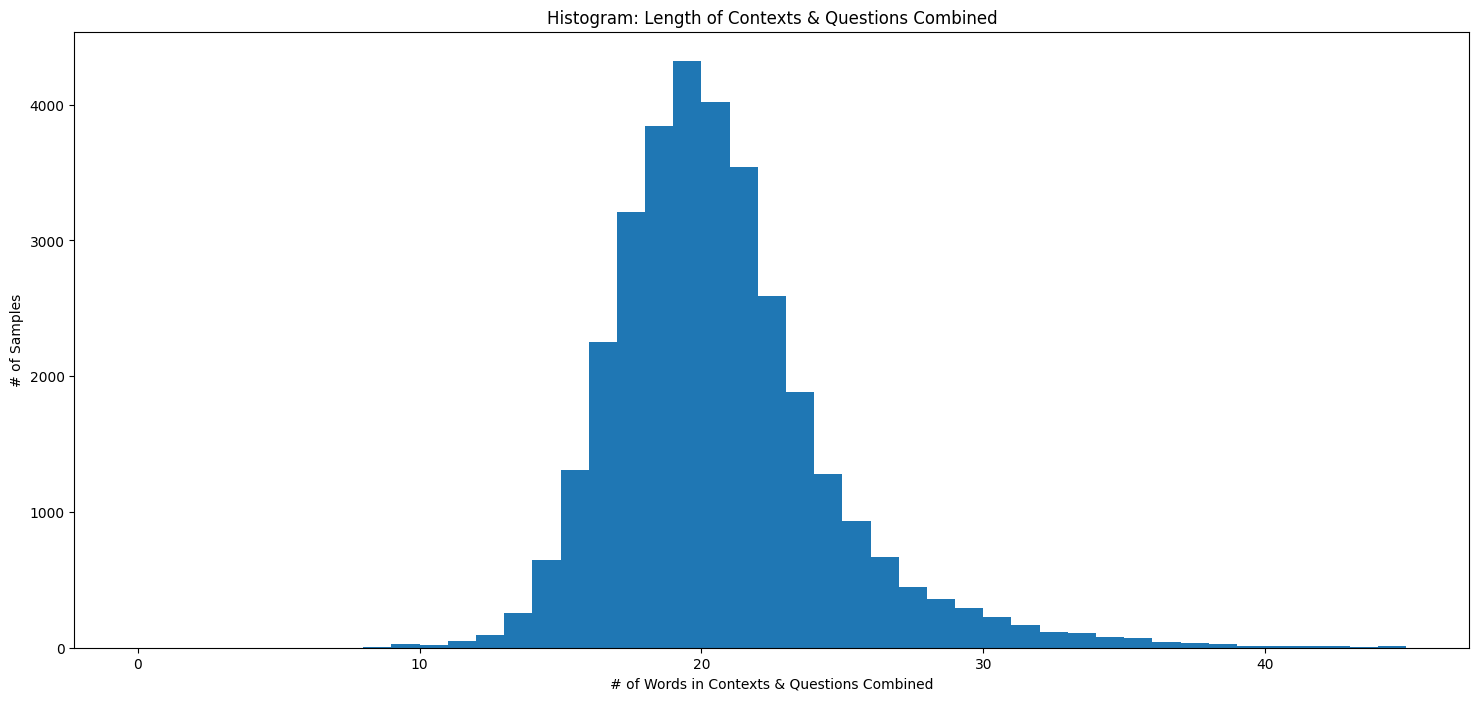

The maximum length of the questions (in words) is 111 words.


In [5]:
train_ds['input_length'] = train_ds['question'].str.split().str.len() + train_ds['context'].str.split().str.len()

n_bin= 45
train_ds.hist('input_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Contexts & Questions Combined')
plt.xlabel('# of Words in Contexts & Questions Combined')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of the questions (in words) is {max(train_ds['input_length'])} words.")

#### Visual: Length of Evaluation Dataset Contexts & Questions Combined (in Words)

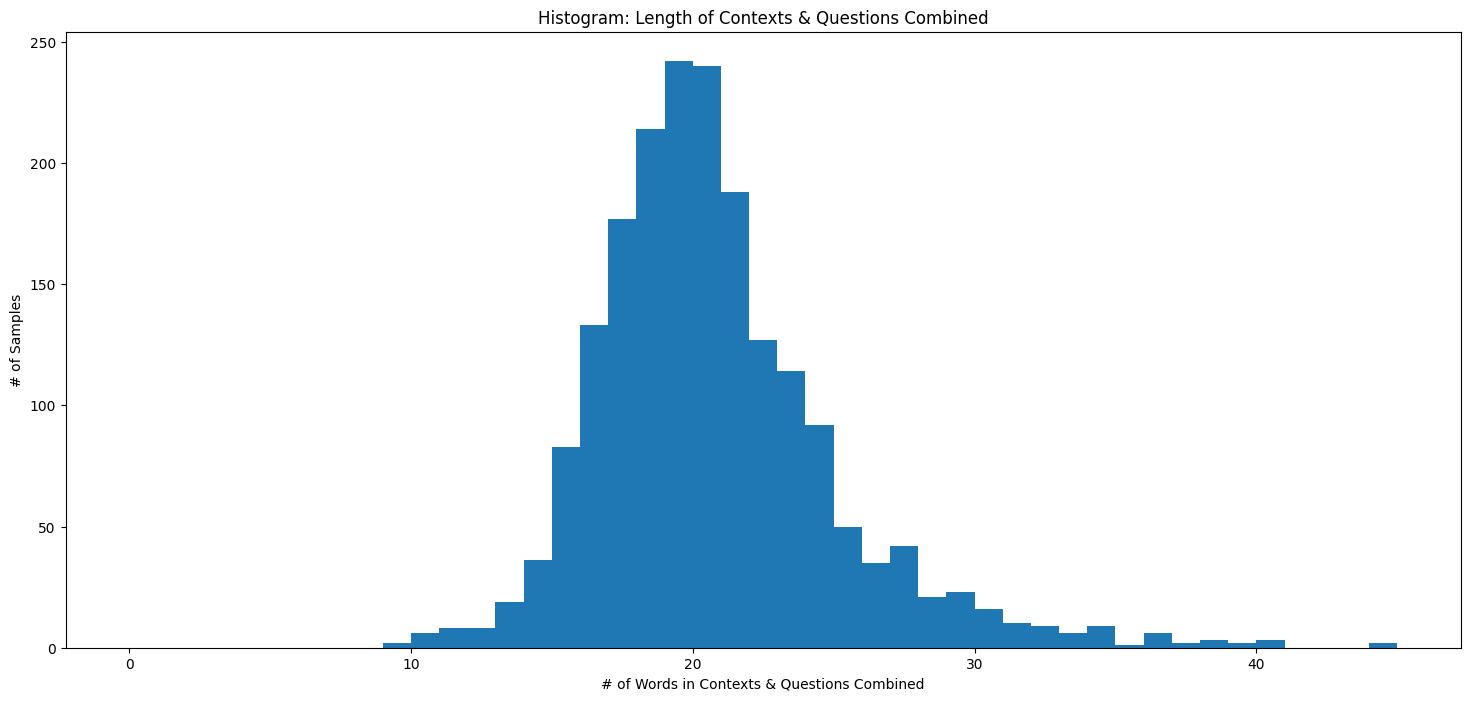

The maximum length of the questions (in words) is 48 words.


In [6]:
eval_ds['input_length'] = eval_ds['question'].str.split().str.len() + eval_ds['context'].str.split().str.len()

n_bin= 45
eval_ds.hist('input_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Contexts & Questions Combined')
plt.xlabel('# of Words in Contexts & Questions Combined')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of the questions (in words) is {max(eval_ds['input_length'])} words.")

#### Remove Overly Lengthy Samples

In [7]:
train_ds = train_ds[train_ds["input_length"] < 46]
eval_ds = eval_ds[eval_ds["input_length"] < 46]

train_ds = train_ds.drop(columns=['input_length'])
eval_ds = eval_ds.drop(columns=['input_length'])

train_ds.reset_index(drop=True, inplace=True)
eval_ds.reset_index(drop=True, inplace=True)

train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32977 entries, 0 to 32976
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   32977 non-null  object
 1   question  32977 non-null  object
 2   0         32977 non-null  object
 3   1         32977 non-null  object
 4   2         32977 non-null  object
 5   label     32977 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [8]:
eval_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929 entries, 0 to 1928
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   1929 non-null   object
 1   question  1929 non-null   object
 2   0         1929 non-null   object
 3   1         1929 non-null   object
 4   2         1929 non-null   object
 5   label     1929 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 90.5+ KB


#### Convert from DataFrame to Dataset

In [9]:
train_dataset = Dataset.from_pandas(train_ds)
eval_dataset = Dataset.from_pandas(eval_ds)

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/datasets/table.py:763: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  return cls(pa.Table.from_pandas(*args, **kwargs))


#### Assign Training & Validation Datasets to DatasetDict

In [10]:
ds = DatasetDict({
    'train' : train_dataset,
    'eval' : eval_dataset,
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(ds['train'].features)

Training Dataset Shape: (32977, 6)
Evaluation Dataset Shape: (1929, 6)
{'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), '0': Value(dtype='string', id=None), '1': Value(dtype='string', id=None), '2': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


#### Create Function to Display an Example Sample

In [11]:
def show_one_example(sample):
    print(f"Context: {sample['context']} {sample['question']}")
    print(f" 0 - {sample['0']}")
    print(f" 1 - {sample['1']}")
    print(f" 2 - {sample['2']}")
    print(f"\nGround Truth: option {sample['label']}")

#### Display an Example Sample

In [12]:
show_one_example(ds['train'][2])

Context: Remy was an expert fisherman and was on the water with Kai. Remy baited Kai's hook. What will Remy want to do next?
 0 - cast the line
 1 - put the boat in the water
 2 - invite Kai out on the boat

Ground Truth: option 0


#### Basic Values/Constants

In [13]:
MODEL_CKPT = "bert-base-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Social_IQa"

STRATEGY = "epoch"
LEARNING_RATE = 5e-5

BATCH_SIZE = 16
NUM_OF_EPOCHS = 3

WEIGHT_DECAY = 0.01
REPORTS_TO = "tensorboard"

set_seed = 42

#### Instantiate Tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, use_fast=True)

#### Create Preprocessing Function

In [15]:
ending_names = ["0", "1", "2"]

def preprocess_function(samples):
    first_sentences = [[context] * len(ending_names) for context in samples['context']]
    
    question_headers = samples['question']
    second_sentences = [[f"{header} {samples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]
    
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])
    
    tokenized_samples = tokenizer(first_sentences, second_sentences, truncation=True)
    return {k: [v[i:i + len(ending_names)] for i in range(0, len(v), len(ending_names))] for k, v in tokenized_samples.items()}

#### Apply Preprocessing Function to Dataset

In [16]:
encoded_ds = ds.map(preprocess_function, batched=True)

encoded_ds['train'].features

A Jupyter Widget

A Jupyter Widget

{'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 '0': Value(dtype='string', id=None),
 '1': Value(dtype='string', id=None),
 '2': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}

#### Instantiate Model

In [17]:
model = AutoModelForMultipleChoice.from_pretrained(MODEL_CKPT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

#### Define TrainingArguments

In [18]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator Class

In [19]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad inputs 
    for the multiple choices received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} 
                               for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        # Unflatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

#### Create Function to Compute Metrics

In [20]:
def compute_metrics(predictions):
    preds, labels = predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == labels).astype(np.float32).mean().item()}

#### Instantiate Trainer

In [21]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Social_IQa into local empty directory.


#### Train Model

In [22]:
train_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 0, 1, question, context, 2. If 0, 1, question, context, 2 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 32977
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6186
  Number of trainable parameters = 109483009


A Jupyter Widget

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.152, 'learning_rate': 4.99919172324604e-05, 'epoch': 0.0}


Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-500
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-500/config.json


{'loss': 0.9, 'learning_rate': 4.5958616230197224e-05, 'epoch': 0.24}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-1000
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-1000/config.json


{'loss': 0.7677, 'learning_rate': 4.191723246039444e-05, 'epoch': 0.48}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-1000/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-1000/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-1500
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-1500/config.json


{'loss': 0.7145, 'learning_rate': 3.787584869059166e-05, 'epoch': 0.73}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-1500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-1500/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-2000
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-2000/config.json


{'loss': 0.694, 'learning_rate': 3.383446492078888e-05, 'epoch': 0.97}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-2000/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-2000/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 0, 1, question, context, 2. If 0, 1, question, context, 2 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1929
  Batch size = 16


A Jupyter Widget

{'eval_loss': 0.9763215780258179, 'eval_accuracy': 0.6018662452697754, 'eval_runtime': 1088.4104, 'eval_samples_per_second': 1.772, 'eval_steps_per_second': 0.111, 'epoch': 1.0}


Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-2500
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-2500/config.json


{'loss': 0.5081, 'learning_rate': 2.9793081150986095e-05, 'epoch': 1.21}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-2500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-2500/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-3000
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-3000/config.json


{'loss': 0.4674, 'learning_rate': 2.575169738118332e-05, 'epoch': 1.45}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-3000/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-3000/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-3500
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-3500/config.json


{'loss': 0.4782, 'learning_rate': 2.1710313611380538e-05, 'epoch': 1.7}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-3500/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-3500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-3500/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-4000
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-4000/config.json


{'loss': 0.4736, 'learning_rate': 1.766892984157776e-05, 'epoch': 1.94}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-4000/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-4000/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 0, 1, question, context, 2. If 0, 1, question, context, 2 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1929
  Batch size = 16


A Jupyter Widget

{'eval_loss': 1.0287446975708008, 'eval_accuracy': 0.6080870628356934, 'eval_runtime': 1054.2503, 'eval_samples_per_second': 1.83, 'eval_steps_per_second': 0.115, 'epoch': 2.0}


Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-4500
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-4500/config.json


{'loss': 0.2801, 'learning_rate': 1.3627546071774977e-05, 'epoch': 2.18}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-4500/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-4500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-4500/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-5000
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-5000/config.json


{'loss': 0.2177, 'learning_rate': 9.586162301972197e-06, 'epoch': 2.42}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-5000/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-5000/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-5500
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-5500/config.json


{'loss': 0.2196, 'learning_rate': 5.544778532169415e-06, 'epoch': 2.67}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-5500/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-5500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-5500/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Social_IQa/checkpoint-6000
Configuration saved in bert-base-uncased-Social_IQa/checkpoint-6000/config.json


{'loss': 0.2288, 'learning_rate': 1.5033947623666343e-06, 'epoch': 2.91}


Model weights saved in bert-base-uncased-Social_IQa/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/checkpoint-6000/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/checkpoint-6000/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 0, 1, question, context, 2. If 0, 1, question, context, 2 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1929
  Batch size = 16


A Jupyter Widget



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 1.6241275072097778, 'eval_accuracy': 0.6127527356147766, 'eval_runtime': 1067.7888, 'eval_samples_per_second': 1.807, 'eval_steps_per_second': 0.113, 'epoch': 3.0}
{'train_runtime': 165777.3226, 'train_samples_per_second': 0.597, 'train_steps_per_second': 0.037, 'train_loss': 0.48742886569328076, 'epoch': 3.0}


#### Evaluate Model

In [23]:
metrics = trainer.evaluate()

print(metrics)

The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 0, 1, question, context, 2. If 0, 1, question, context, 2 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1929
  Batch size = 16


A Jupyter Widget

{'eval_loss': 1.6241275072097778, 'eval_accuracy': 0.6127527356147766, 'eval_runtime': 1070.1235, 'eval_samples_per_second': 1.803, 'eval_steps_per_second': 0.113, 'epoch': 3.0}


#### Push to HuggingFace Hub

In [24]:
trainer.push_to_hub()

Saving model checkpoint to bert-base-uncased-Social_IQa
Configuration saved in bert-base-uncased-Social_IQa/config.json
Model weights saved in bert-base-uncased-Social_IQa/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Social_IQa/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Social_IQa/special_tokens_map.json


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/bert-base-uncased-Social_IQa
   906072a..e783ba8  main -> main

Dropping the following result as it does not have all the necessary fields:
{'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.6127527356147766}]}
To https://huggingface.co/DunnBC22/bert-base-uncased-Social_IQa
   e783ba8..e8eeb94  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Social_IQa/commit/e783ba81d690ad1e69fcfd9b1068720892dcec97'

### Notes & Other Takeaways From This Project
****
- It looks like 67.5 percent is the State of the Art value for BERT (the 'Large' BERT checkpoint, not the base checkpoint) on Multiple Choice with the SWAG dataset. Having done some smaller initial test runs and trying this project with distilBERT originally, I am sure that with more training (4 or 5 epochs instead of 3), I could achieve metrics more in line with the State of the Art value. 
****

### Citation

- Model Checkpoint
    - @article{DBLP:journals/corr/abs-1810-04805,
  author    = {Jacob Devlin and
               Ming{-}Wei Chang and
               Kenton Lee and
               Kristina Toutanova},
  title     = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language
               Understanding},
  journal   = {CoRR},
  volume    = {abs/1810.04805},
  year      = {2018},
  url       = {http://arxiv.org/abs/1810.04805},
  archivePrefix = {arXiv},
  eprint    = {1810.04805},
  timestamp = {Tue, 30 Oct 2018 20:39:56 +0100},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}